In [1]:
import yfinance as yf
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, round as spark_round
from pyspark.sql.window import Window
import os

# 環境変数設定（重要: WindowsのSparkでParquet書き込み対策）
try:
    import env_setup
except ImportError:
    pass  # なければ無視

In [2]:
spark = SparkSession.builder \
    .appName("LoadParquetExample") \
    .master("local[*]") \
    .getOrCreate()

In [3]:
import os 
os.getcwd()

os.listdir()


['.ipynb_checkpoints',
 'env_setup.py',
 'process_prices.py',
 'test.py',
 'test_notebook.ipynb',
 'test_notebook2.ipynb',
 '__pycache__']

In [4]:
os.path.exists("../data/processed/stock_prices.parquet")


True

In [5]:
df = spark.read.parquet("../data/processed/stock_prices.parquet")
df.groupBy("Ticker").avg("Return(%)").show()


+------+--------------------+
|Ticker|      avg(Return(%))|
+------+--------------------+
| VOD.L|-0.05571347678369184|
|HSBA.L|0.014597961494903756|
|  BP.L|0.005158550396376...|
+------+--------------------+



In [6]:
df.show(5)

+-------------------+------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+-----------------+---------+
|               Date|Ticker|             Open|             High|              Low|            Close|        Adj Close|  Volume|       Prev_Close|Return(%)|
+-------------------+------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+-----------------+---------+
|2018-01-02 00:00:00|  BP.L|524.2000122070312|524.2999877929688|514.2999877929688|            517.5|515.2674560546875|20152548|             null|     null|
|2018-01-03 00:00:00|  BP.L|519.2000122070312|525.5999755859375|518.7999877929688|524.2000122070312|521.9384155273438|27207749|            517.5|     1.29|
|2018-01-04 00:00:00|  BP.L|529.0999755859375|530.5999755859375|527.2000122070312|            530.0|527.7135620117188|32592520|524.2000122070312|     1.11|
|2018-01-05 00:00:00|  BP.L|            530.0|531.2999877929688|

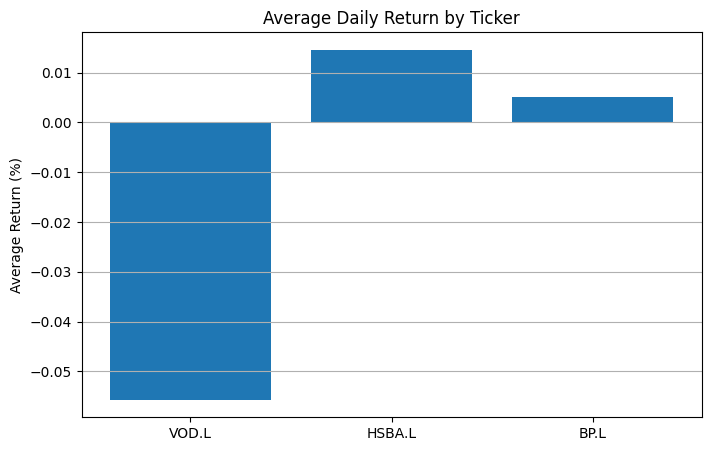

In [13]:
import matplotlib.pyplot as plt

# Step 1: Collect average returns by Ticker
avg_returns = df.groupBy("Ticker").avg("Return(%)").toPandas()

# Step 2: Rename column for clarity
avg_returns.columns = ["Ticker", "Average Return (%)"]

# Step 3: Plot
plt.figure(figsize=(8, 5))
plt.bar(avg_returns["Ticker"], avg_returns["Average Return (%)"])
plt.title("Average Daily Return by Ticker")
plt.ylabel("Average Return (%)")
plt.grid(axis="y")
plt.show()

In [11]:
avg_returns

,Ticker,Average Return (%)
0,VOD.L,-0.055713
1,HSBA.L,0.014598
2,BP.L,0.005159


In [16]:
df_pd = df.toPandas()
df_vod = df_pd[df_pd['Ticker'] == 'VOD.L']
df_vod

c:\Users\Pupi\Desktop\Git project\stock-trend-etl-spark\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,Prev_Close,Return(%)
3534,2018-01-02,VOD.L,235.149994,235.300003,233.100006,233.800003,232.580856,28518111,NaN,NaN
3535,2018-01-03,VOD.L,234.399994,234.399994,232.050003,233.449997,232.232651,36335155,233.800003,-0.15
3536,2018-01-04,VOD.L,234.250000,235.300003,233.000000,235.300003,234.073044,65362950,233.449997,0.79
3537,2018-01-05,VOD.L,236.000000,236.899994,234.699997,236.800003,235.565186,69338309,235.300003,0.64
3538,2018-01-08,VOD.L,236.600006,238.800003,236.250000,237.649994,236.410767,58835938,236.800003,0.36
...,...,...,...,...,...,...,...,...,...,...
5296,2024-12-20,VOD.L,66.839996,66.940002,66.120003,66.500000,66.480278,153387989,67.059998,-0.84
5297,2024-12-23,VOD.L,66.919998,66.919998,66.279999,66.480003,66.460289,63293094,66.500000,-0.03
5298,2024-12-24,VOD.L,66.800003,67.940002,66.620003,67.760002,67.739906,27798312,66.480003,1.93
5299,2024-12-27,VOD.L,67.519997,67.959999,66.800003,67.339996,67.320030,60270857,67.760002,-0.62


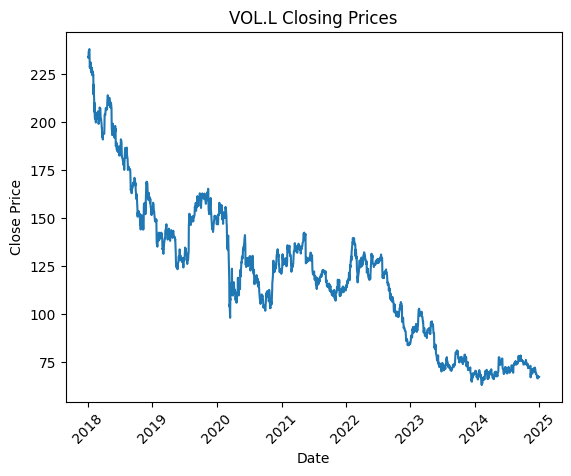

In [23]:
import matplotlib.pyplot as plt
plt.plot(df_vod['Date'], df_vod['Close'])
plt.title('VOL.L Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.show()

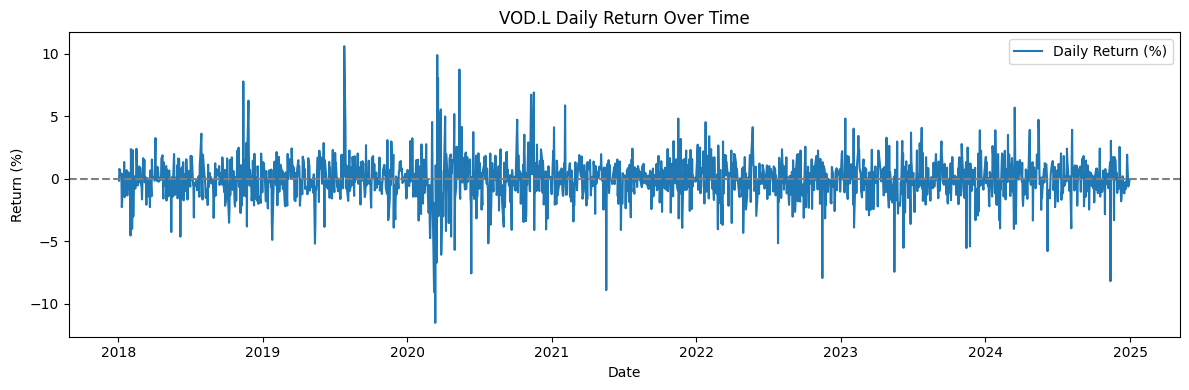

In [38]:
# Plot return over time
plt.figure(figsize=(12, 4))
plt.plot(df_vod["Date"], df_vod["Return(%)"], label="Daily Return (%)")
plt.title("VOD.L Daily Return Over Time")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

I've noticed large positive spikes before 2020. On the other hand, there are negative spikes after 2020. This suggests that COVID-19 may have affected VOD.L's stock price.